In [1]:
# let's import important libraries
import numpy as np
from numpy import hstack
from matplotlib import pyplot as plt
import math

import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Input, Dropout, Flatten
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.models import Model
from keras.layers import ConvLSTM2D

import pandas as pd

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error


In [2]:
# Going to use following 6 different areas for amnomalies

dataframe = pd.read_csv('../extract-data/normal following/ICAB1/01_icab1_reverse_straight0_2021-03-26-13-25-50_0/icab1-mavros-imu-data.csv', usecols=[18,19,20,30,31,32])

dataframe

,angular_velocity.x,angular_velocity.y,angular_velocity.z,linear_acceleration.x,linear_acceleration.y,linear_acceleration.z
0,0.001369,0.003281,-0.003239,0.421686,-0.215746,9.885103
1,-0.000466,0.002388,-0.003293,0.411879,-0.294199,9.875297
2,-0.001836,0.002453,-0.002719,0.411879,-0.304006,9.894910
3,-0.001633,0.004359,-0.001778,0.411879,-0.294199,9.875297
4,0.000206,0.005041,-0.002078,0.402073,-0.264780,9.885103
...,...,...,...,...,...,...
1442,-0.001596,0.002113,-0.002849,0.362846,-0.392266,9.826263
1443,-0.001849,0.004086,-0.001547,0.284393,-0.451106,9.855683
1444,-0.001895,0.003308,-0.000129,0.284393,-0.382459,9.865490
1445,-0.001457,0.003179,0.001361,0.382459,-0.411879,9.894910


In [3]:
# Change the data to the vector format size of 1447 rows x 6 columns
dataset_array = dataframe.values
data_as_array = dataset_array.astype(float)
print(data_as_array)

[[ 1.36923930e-03  3.28069180e-03 -3.23926657e-03  4.21685950e-01
  -2.15746300e-01  9.88510320e+00]
 [-4.66197263e-04  2.38821283e-03 -3.29279620e-03  4.11879300e-01
  -2.94199500e-01  9.87529655e+00]
 [-1.83554413e-03  2.45284103e-03 -2.71887053e-03  4.11879300e-01
  -3.04006150e-01  9.89490985e+00]
 ...
 [-1.89487496e-03  3.30761075e-03 -1.28845684e-04  2.84392850e-01
  -3.82459350e-01  9.86548990e+00]
 [-1.45718874e-03  3.17933410e-03  1.36134913e-03  3.82459350e-01
  -4.11879300e-01  9.89490985e+00]
 [ 3.36184166e-05  2.78925523e-03  2.90202908e-04  4.51105900e-01
  -4.02072650e-01  9.85568325e+00]]


In [4]:
angular_velocity_x = dataframe["angular_velocity.x"]
angular_velocity_y = dataframe["angular_velocity.y"]
angular_velocity_z = dataframe["angular_velocity.z"]

linear_acceleration_x = dataframe["linear_acceleration.x"]
linear_acceleration_y = dataframe["linear_acceleration.y"]
linear_acceleration_z = dataframe["linear_acceleration.z"]

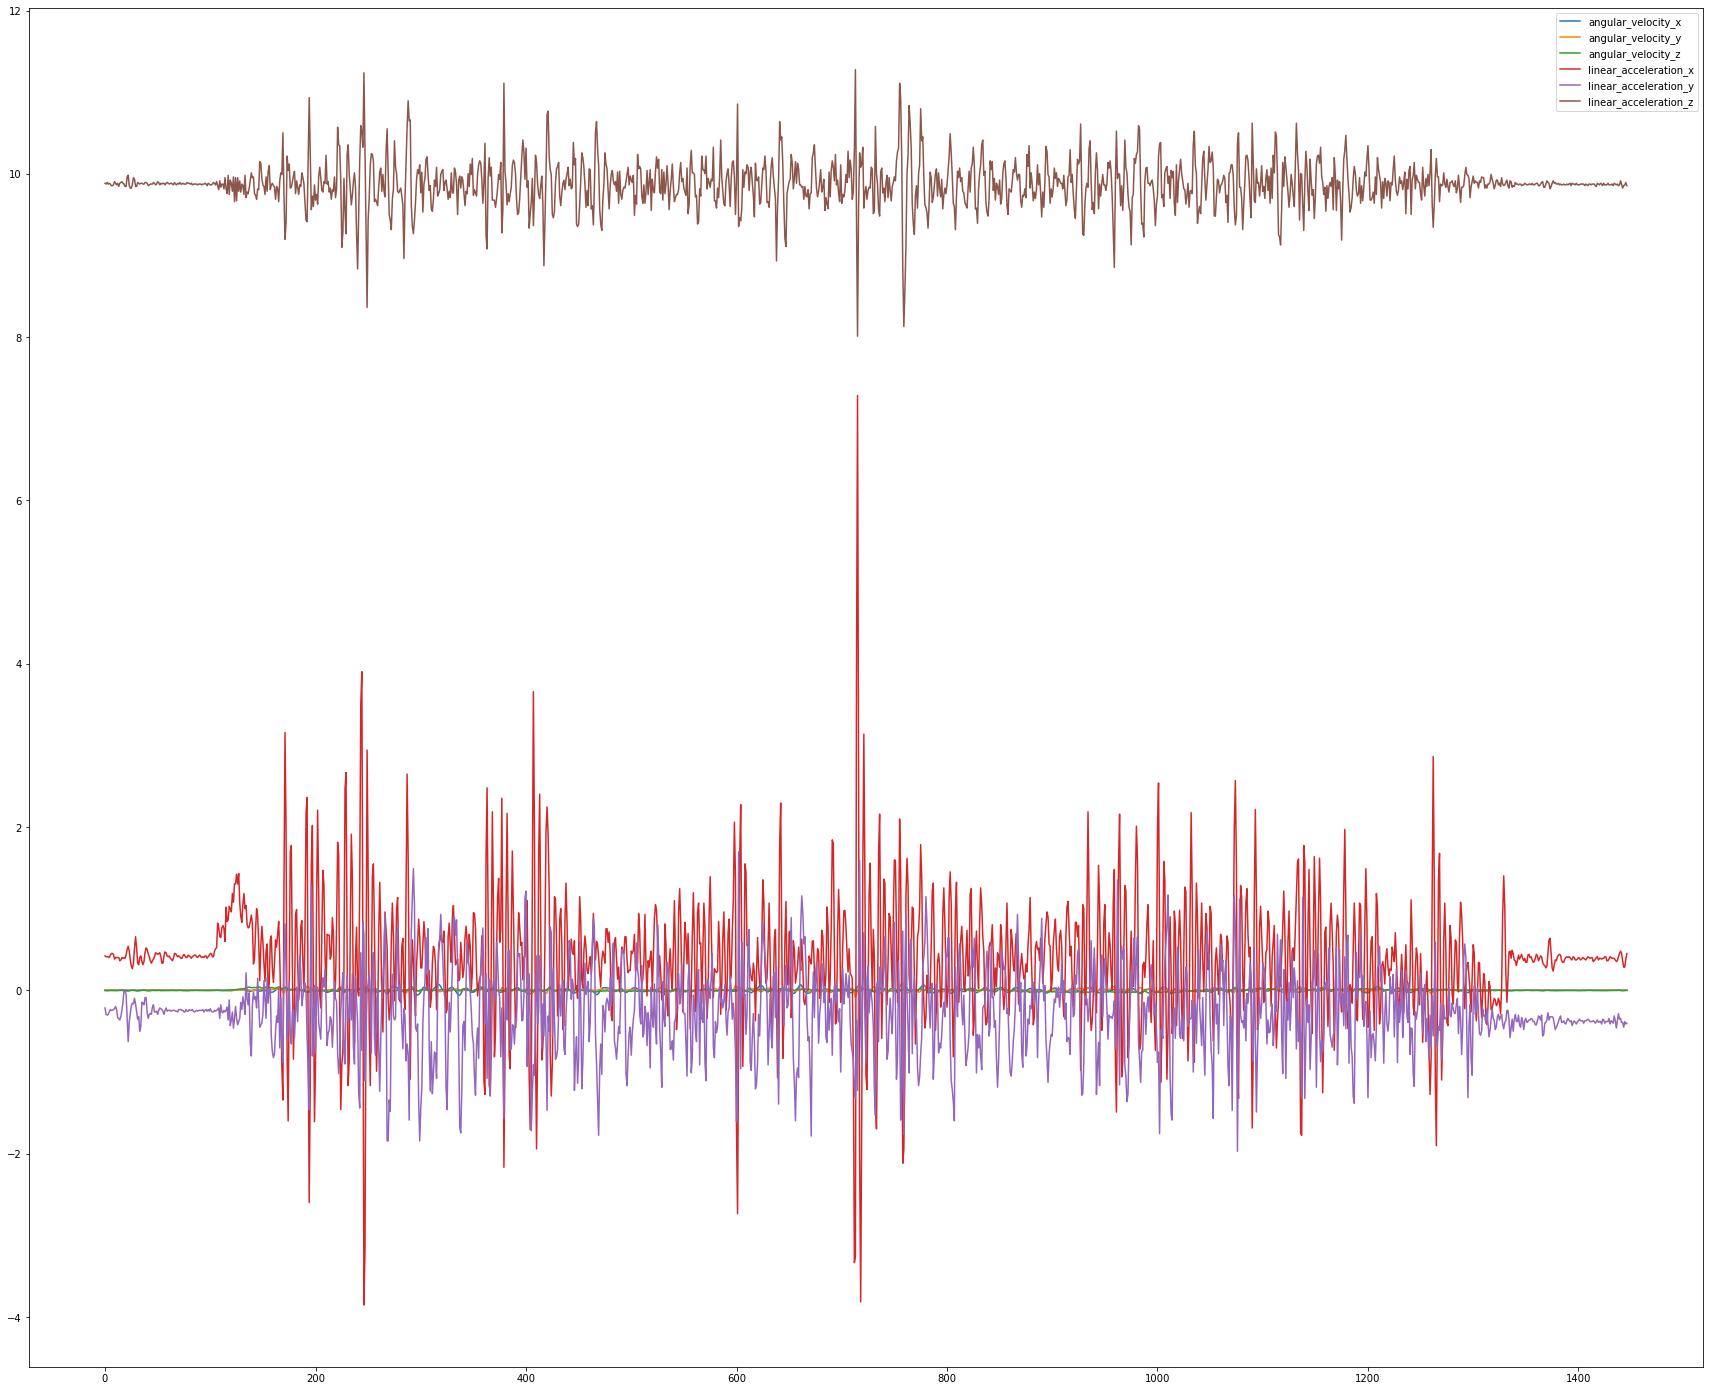

In [5]:
# plot the variation vs time i
fig, axes = plt.subplots(1,1, figsize = (30,25))
plt.plot(angular_velocity_x)
plt.plot(angular_velocity_y)
plt.plot(angular_velocity_z)

plt.plot(linear_acceleration_x)
plt.plot(linear_acceleration_y)
plt.plot(linear_acceleration_z)

plt.legend(["angular_velocity_x", "angular_velocity_y", "angular_velocity_z", "linear_acceleration_x", "linear_acceleration_y", "linear_acceleration_z"])


In [6]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
    X = []
    Y = []

    for i in range(len(sequences) - (n_steps+1)): # check the sequence
    # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix, :]
        # for the seq_x ==> put the all values under the consecutive 3 lists..(Consider the nested lists)

        X.append(seq_x)
        Y.append(seq_y)
    return np.array(X), np.array(Y)
    # this output the sequence, that has the time step of 3 
    

In [7]:
# use whole data set and divides it for training and testing
# lets take the 2/3 of whole data set as training and 1/3 for testing
# declare the size of the testing and training sets
training_size = int(0.66 * len(data_as_array))
testing_size = len(data_as_array) - training_size

# create a training set
train_x = data_as_array[0:training_size, :]

# create a testing set
test_x = data_as_array[training_size:len(data_as_array), :]

print(train_x.shape)
print(test_x.shape)


(955, 6)
(492, 6)


In [8]:
# preprocessing the data set

# scaling the dataset
# check the min value of data set and it is appointed as zero.... max value is appointed as one
scaler = MinMaxScaler(feature_range=(0, 1)) # define a scaler of range (0,1)
train_x_scaled = scaler.fit_transform(train_x)
test_x_scaled = scaler.fit_transform(test_x)

print(train_x_scaled.shape)
print(test_x_scaled.shape)


# split data set to multivariant samples using above defined function. lets take steps looks back as 3
x_train, y_train = split_sequences(train_x_scaled, 3)
x_test, y_test = split_sequences(test_x_scaled, 3)
# y_train is 2D .. should be reshaped to 3D
y_train = y_train.reshape(y_train.shape[0], 1, y_train.shape[1])
y_test = y_test.reshape(y_test.shape[0], 1, y_test.shape[1])

x_train_zero = np.zeros((x_train.shape[0],1,6))
x_test_zero = np.zeros((x_test.shape[0],1,6))

print(x_train.shape)
print(y_train.shape)



(955, 6)
(492, 6)
(951, 3, 6)
(951, 1, 6)


#### The input to every LSTM layer must be three-dimensional.

#### The three dimensions of this input are:

1. __Samples :__ One sequence is one sample. A batch is comprised of one or more samples.
2. __Time Steps:__ One time step is one point of observation in the sample.
3. __Features:__ One feature is one observation at a time step.

In [9]:
n_input=6
n_output=6

encoder_inputs = Input(shape=(3, n_input)) # define inputs for the model(shape of x train(3 x 6))
encoder = LSTM(256, return_state=True) # create LSTM model with 256 LSTM units
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
encoder_states = [state_h, state_c]
# define training decoder
decoder_inputs = Input(shape=(1,n_output)) # shape of zero vector 1 x 6
decoder_lstm = LSTM(256, return_sequences=True)
decoder_outputs = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = Dense(n_output, activation='tanh')
decoder_outputs = decoder_dense(decoder_outputs)
model = Model([encoder_inputs, decoder_inputs], decoder_outputs) # model take the inputs and outputs
model.compile(optimizer="adam",loss="mse",metrics=["accuracy"])
model.summary()
print('Training ....................................................................')

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 3, 6)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1, 6)]       0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 256), (None, 269312      input_1[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 1, 256)       269312      input_2[0][0]                    
                                                                 lstm[0][1]                   

In [10]:
# fit the model for calculate losses and accuracies
history=model.fit([x_train,x_train_zero], y_train,validation_data=([x_test,x_test_zero],y_test), verbose = 1, epochs=500)

Epoch 1/500
30/30 [==============================] - 8s 132ms/step - loss: 0.0942 - accuracy: 0.3632 - val_loss: 0.0213 - val_accuracy: 0.4467
Epoch 2/500
30/30 [==============================] - 1s 17ms/step - loss: 0.0138 - accuracy: 0.5205 - val_loss: 0.0187 - val_accuracy: 0.4467
Epoch 3/500
30/30 [==============================] - 1s 17ms/step - loss: 0.0121 - accuracy: 0.5432 - val_loss: 0.0178 - val_accuracy: 0.4631
Epoch 4/500
30/30 [==============================] - 1s 19ms/step - loss: 0.0099 - accuracy: 0.5463 - val_loss: 0.0163 - val_accuracy: 0.5287
Epoch 5/500
30/30 [==============================] - 1s 19ms/step - loss: 0.0083 - accuracy: 0.6356 - val_loss: 0.0150 - val_accuracy: 0.5922
Epoch 6/500
30/30 [==============================] - 1s 18ms/step - loss: 0.0077 - accuracy: 0.6318 - val_loss: 0.0139 - val_accuracy: 0.5984
Epoch 7/500
30/30 [==============================] - 1s 18ms/step - loss: 0.0077 - accuracy: 0.6667 - val_loss: 0.0136 - val_accuracy: 0.5717
Epoch

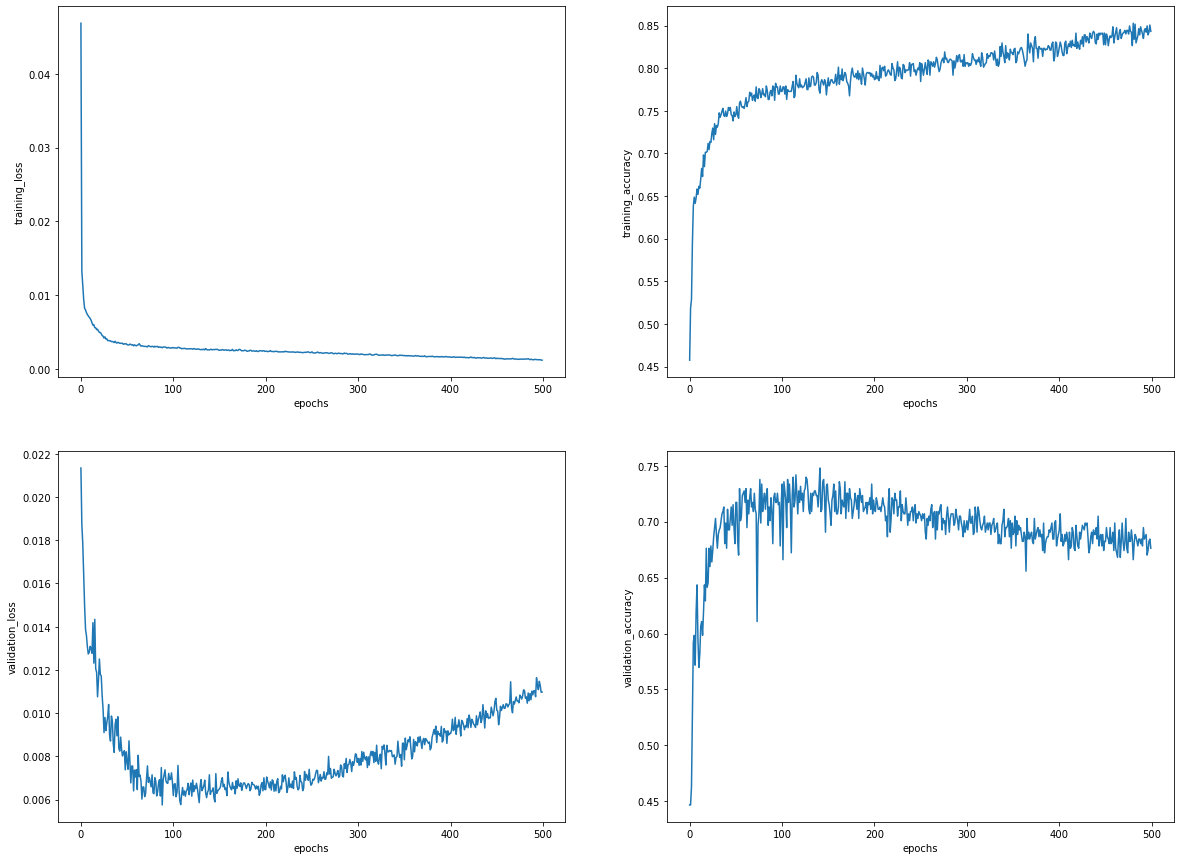

In [12]:
training_loss, training_accuracy, validation_loss, validation_accuracy = (history.history['loss'], history.history['accuracy'], history.history['val_loss'], history.history['val_accuracy'])
fig, axes = plt.subplots(2,2, figsize = (20,15))

axes[0][0].plot(training_loss)  
axes[0][0].set_xlabel("epochs")
axes[0][0].set_ylabel("training_loss")

fig.savefig('training_loss.png',transparent=True)

#===============================================

axes[0][1].plot(training_accuracy)  
axes[0][1].set_xlabel("epochs")
axes[0][1].set_ylabel("training_accuracy")

fig.savefig('training_accuracy.png',transparent=True)

#===============================================

axes[1][0].plot(validation_loss)  
axes[1][0].set_xlabel("epochs")
axes[1][0].set_ylabel("validation_loss")

fig.savefig('validation_loss.png',transparent=True)

#===============================================

axes[1][1].plot(validation_accuracy)  
axes[1][1].set_xlabel("epochs")
axes[1][1].set_ylabel("validation_accuracy")

fig.savefig('validation_accuracy.png',transparent=True)

plt.show()